# Random Forest

This notebook contains the code, results, and interpretation of fitting a Random Forest model to predict the pathological response to neoadjuvant chemoradiation of a cohort of 49 patients with locally advanced rectal cancer.


In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns

In [2]:
if not os.path.exists('results/01_RandomForest'):
    os.makedirs('results/01_RandomForest')

## Data reading
The selected data is read according to the results from the notebook `01_variable_selection`, which contain 39 cases labeled as `1` for non-complete response and 10 cases labeled as `0` for complete response.

In [3]:
# Read data and get response
data = pd.read_csv("data/selected_features.csv")
response = data['response']
data = data.drop(['response'], axis=1)
data.head()

,VolumeNum,GrayLevelNonUniformityNormalized.1,Elongation,InterquartileRange,SizeZoneNonUniformityNormalized,SmallAreaEmphasis,Strength,SurfaceVolumeRatio,Edad,Genero,Localización,N_clinico,Invasion_mesorecto,CEA_basal
0,1,0.026988,0.511936,197.0,0.444987,0.693348,0.882716,0.134019,64,0,0,1,1,0
1,1,0.061615,0.700567,111.0,0.328651,0.592024,1.579438,0.145663,72,0,1,2,1,0
2,1,0.043117,0.728945,97.0,0.397054,0.654634,2.444571,0.133402,68,0,0,1,0,1
3,1,0.026388,0.861587,802.0,0.541238,0.763957,0.398438,0.097681,65,0,1,0,0,0
4,1,0.032382,0.776489,111.0,0.436163,0.686958,0.987403,0.119279,72,1,1,1,0,0


## *Oversampling* using SMOTE

Using the SMOTE technique, oversampling of the minority category will be performed to balance both categories in the response variable. This technique involves synthesizing new data for the minority category from existing data by using an interpolation algorithm between neighboring points. This approach increases the number of data points in the minority category without directly duplicating them, which helps improve the model's performance in classifying that category.


In [4]:
# Oversample data (repeat until no NA is produced)
smote = SMOTE(random_state=666, k_neighbors=6)
while True:
    data, response = smote.fit_resample(data, response)
    idx_na = data.isna().any(axis=1)
    if idx_na.any():
        data = data.loc[~ idx_na, :].reset_index(drop=True)
        response = response[~ idx_na].reset_index(drop=True)
    else:
        break
# Check that the oversampling has worked
print(Counter(response))

Counter({1: 39, 0: 39})



After performing the oversampling, an exploratory PCA is conducted to verify that the structure of the data has been maintained.


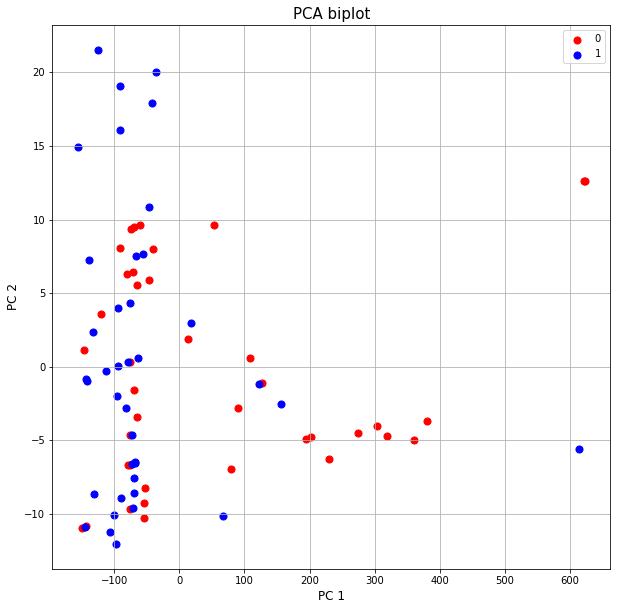

In [5]:
# Fit PCA to see data structure
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
data_scaled = pd.DataFrame(data, columns=data.columns)

# PCA
pca = PCA(n_components=2)
pca_fit = pca.fit_transform(data_scaled)
pca_fit_df = pd.DataFrame(data = pca_fit,
                          columns = ['principal component 1',
                                     'principal component 2'])
pca_fit_df['response'] = response

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC 1', fontsize = 12)
ax.set_ylabel('PC 2', fontsize = 12)
ax.set_title('PCA biplot', fontsize = 15)
diags=[0,1]
colors=['r','b']
for diag, color in zip(diags,colors):
    i = pca_fit_df['response'] == diag
    ax.scatter(pca_fit_df.loc[i, 'principal component 1']
               , pca_fit_df.loc[i, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(diags)
ax.grid()

## Random Forest Fitting

First, the data is split into training and test subsets with a 0.75:0.25 ratio. This ensures that the model is trained on a significant amount of data while having an independent dataset available to evaluate its performance later. This division is a common practice in machine learning, as it provides a reliable estimate of the model's generalization to new, unseen data during training.

In [6]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(data, response,
                                                    random_state = 123,
                                                    test_size = 0.25)

### Optimal Hyperparameter Search

Through grid search, an attempt is made to optimize the hyperparameters of the random forest to find the configuration that maximizes the model's performance. Grid search systematically explores all possible combinations of specified hyperparameter values, training a model for each combination and evaluating its performance on a validation dataset.

For random forest, some of the most important hyperparameters to optimize for maximizing model performance are:

  * `n_estimators`: This hyperparameter determines the number 
      of decision trees to be included in the forest. A higher 
      number of trees generally improves the model's accuracy, 
      but it can also increase training and execution time. 
      It is recommended to start with a low value (e.g., 100) 
      and gradually increase it until the optimal value is found.
  * `max_depth`: This hyperparameter controls the complexity of 
      each decision tree. A higher value allows the model to capture 
      more complex patterns in the data, but it can also increase 
      the risk of overfitting. It is recommended to start with a 
      low value (e.g., 5) and gradually increase it until the 
      optimal value is found.
  * `min_samples_split`: This hyperparameter indicates the minimum 
      number of samples required to consider a split in a decision 
      tree. A higher value can improve the model's accuracy but may 
      also increase training and execution time. It is recommended 
      to start with a low value (e.g., 2) and gradually increase it 
      until the optimal value is found.
  * `min_samples_leaf`: This hyperparameter indicates the minimum 
      number of samples that must be in each leaf of a decision tree. 
      A higher value can improve the model's accuracy but may also 
      increase the risk of overfitting. It is recommended to start 
      with a low value (e.g., 1) and gradually increase it until the 
      optimal value is found.


In [7]:
# Hyperparameter tuning by grid search
param_grid = {'n_estimators': [100, 200, 300],
              'max_depth': [None, 5, 10],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 5, 10]}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42),
                           param_grid, cv=5, scoring='f1_macro')
grid_search.fit(X_train, y_train)

# Get best model and best model parameters
best_model = grid_search.best_estimator_
print('Best hyperparameters:',  grid_search.best_params_)

Best hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


The best random forest model has selected the following as the optimal hyperparameters:
  * `max_depth`: None,
  * `min_samples_leaf`: 1,
  * `min_samples_split`: 2,
  * `n_estimators`: 300
  
### Model Performance Metrics

Using cross-validation techniques, the accuracy, precision, *recall*, and area under the curve (AUC) have been determined. These metrics provide valuable insights into the model's ability to generalize to new, unseen data during training.

Specifically, the *k-fold cross-validation* method was used, with 10 folds. This technique involves dividing the dataset into k random subsets (10 in this case). The model is then trained k times, each time using a different subset as the validation set and the remaining subsets as the training set. Finally, the performance metrics obtained in each iteration are averaged to provide a more robust estimate of the model's overall performance

In [8]:
# Get metrics with the best model with k-fold cross validation
kf = KFold(n_splits=10, shuffle=True, random_state=123)

accuracy = []
precision = []
recall = []
f1 = []
auc = []
confusion_matrices = []

for train_index, val_index in kf.split(data,):
    X_train_fold, X_val_fold = data.iloc[train_index], data.iloc[val_index]
    y_train_fold, y_val_fold = response.iloc[train_index], response.iloc[val_index]
    
    best_model.fit(X_train_fold, y_train_fold)
    y_pred = best_model.predict(X_val_fold)
    y_pred_proba = best_model.predict_proba(X_val_fold)[:, 1]
    
    accuracy.append(accuracy_score(y_val_fold, y_pred))
    precision.append(precision_score(y_val_fold, y_pred))
    f1.append(f1_score(y_val_fold, y_pred))
    recall.append(recall_score(y_val_fold, y_pred))
    auc.append(roc_auc_score(y_val_fold, y_pred_proba))
    confusion_matrices.append(confusion_matrix(y_val_fold, y_pred))

print("Accuracy:", np.round(np.mean(accuracy), 3))
print("Precision:", np.round(np.mean(precision), 3))
print("Recall:", np.round(np.mean(recall), 3))
print("F1:", np.round(np.mean(f1), 3))
print("AUC:", np.round(np.mean(auc), 3))

Accuracy: 0.896
Precision: 0.872
Recall: 0.875
F1: 0.86
AUC: 0.945


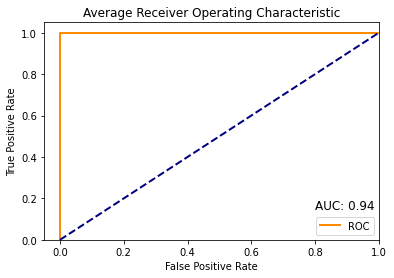

In [9]:
# Determinar y representar el AUC
fpr, tpr, _ = roc_curve(y_test, best_model.predict(X_test))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Average Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.text(0.8, 0.15, f'AUC: {np.mean(auc):.2f}', fontsize=12)
plt.savefig('results/01_RandomForest/roc_curve.png', dpi=300,
            bbox_inches='tight')
plt.show()

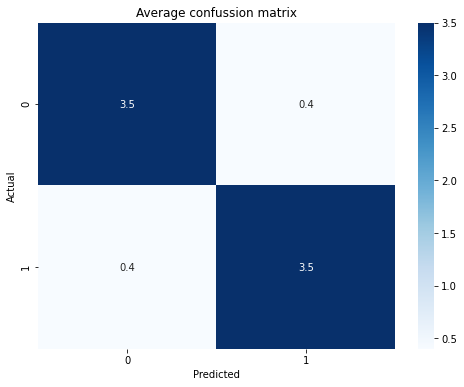

In [10]:
# Representar la matriz de confusión promedio
confusion_matrix_mean = np.mean(confusion_matrices, axis=0)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_mean, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Average confussion matrix')
plt.savefig('results/01_RandomForest/confussion_matrix.png', dpi=300,
            bbox_inches='tight')
plt.show()

Overall, the performance metrics for the selected hyperparameters indicate that the model performs well, with an accuracy of 89.6%, precision of 87.2%, recall of 87.5%, and an AUC of 0.945. The F1 score is 0.86.

These results suggest that the model can classify instances in the dataset with a high degree of reliability. The precision and recall, in particular, show that the model is effective both in correctly identifying positive cases and in avoiding false positives.

However, the high AUC value (0.94) may indicate some level of overfitting. An AUC close to 1 can imply that the model is learning patterns that are too specific to the training dataset, which could negatively impact its performance on new, unseen data.

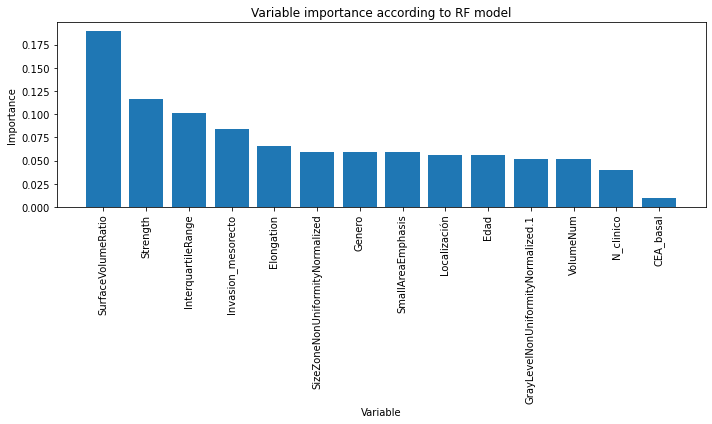

In [11]:
# Get variable importance
feature_importances = best_model.feature_importances_
feature_importances_df = pd.DataFrame({
    'Variable': data.columns,
    'Importance': feature_importances
})
feature_importances_df = feature_importances_df.sort_values(by='Importance',
                                                            ascending=False)
feature_importances_df.to_csv('results/01_RandomForest/var_imp.csv',
                             index=False)

# Plot
plt.figure(figsize=(10, 6))
plt.bar(feature_importances_df['Variable'],
        feature_importances_df['Importance'])
plt.xlabel('Variable')
plt.ylabel('Importance')
plt.title('Variable importance according to RF model')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('results/01_RandomForest/var_imp.png', dpi=300,
            bbox_inches='tight')
plt.show()

The figure shows the relative importance of the variables according to the *random forest* model. It is observed that the variables with the highest importance are`SurfaceVolumeRatio`, `Strength`,
`InterquartileRange` y `Invasion_mesorecto`. Beyond these, the rest of the variables have similar importance, while `CEA_basal` has residual importance.